In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [36]:


import os
import time
import random
import copy  # <-- Add this import!
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.models import VGG16_Weights, MobileNet_V3_Large_Weights, DenseNet121_Weights

In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:

# Define dataset path
dataset_path = "/kaggle/input/eye-disease-image-dataset/Augmented Dataset/Augmented Dataset"


In [17]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [18]:

# Load the dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Define train/val/test split ratios
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensure total sums up correctly

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [19]:

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# Number of classes
num_classes = len(full_dataset.classes)
print(f"Classes: {full_dataset.classes}, Total Classes: {num_classes}")

# Function to count images per class
def count_images_per_class(dataset):
    class_counts = {cls: 0 for cls in dataset.dataset.classes}
    for _, label in dataset.dataset.samples:
        class_counts[dataset.dataset.classes[label]] += 1
    return class_counts

# Get the count of images per class
class_counts = count_images_per_class(train_dataset)

# Print the count of images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

Classes: ['Central Serous Chorioretinopathy-Color Fundus', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa'], Total Classes: 10
Class 'Central Serous Chorioretinopathy-Color Fundus': 606 images
Class 'Diabetic Retinopathy': 3444 images
Class 'Disc Edema': 762 images
Class 'Glaucoma': 2880 images
Class 'Healthy': 2676 images
Class 'Macular Scar': 1937 images
Class 'Myopia': 2251 images
Class 'Pterygium': 102 images
Class 'Retinal Detachment': 750 images
Class 'Retinitis Pigmentosa': 834 images


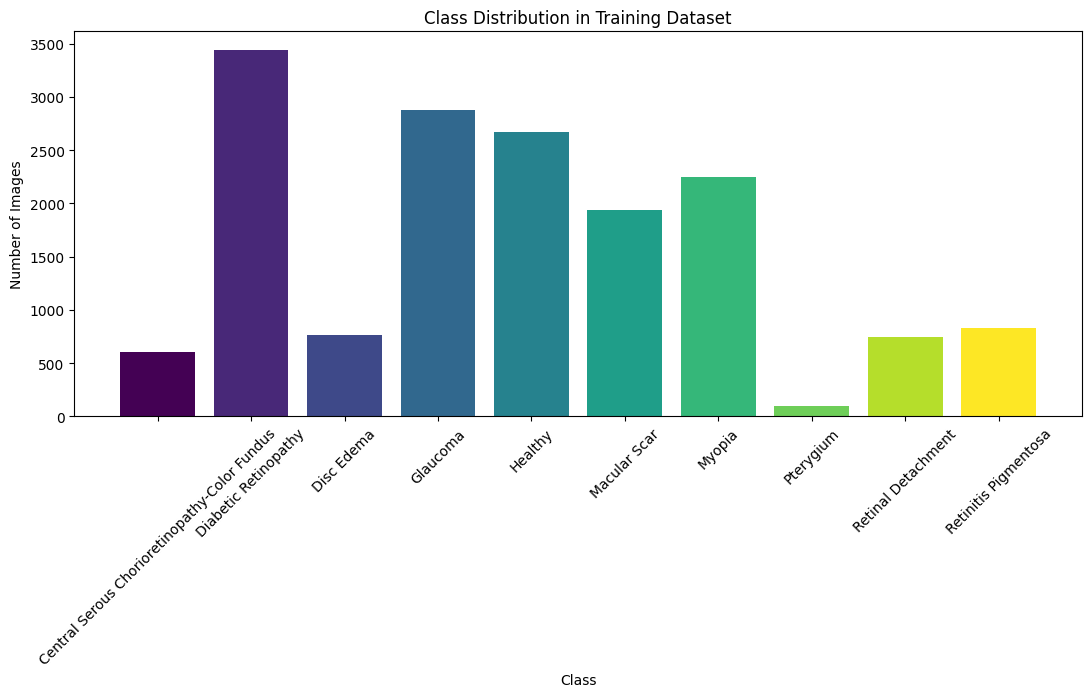

In [21]:

train_class_counts = count_images_per_class(train_dataset)

# Generate a list of colors based on the number of classes
colors = plt.cm.viridis(np.linspace(0, 1, len(train_class_counts)))

# Plot class distribution with different colors
plt.figure(figsize=(13, 5))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color=colors)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()

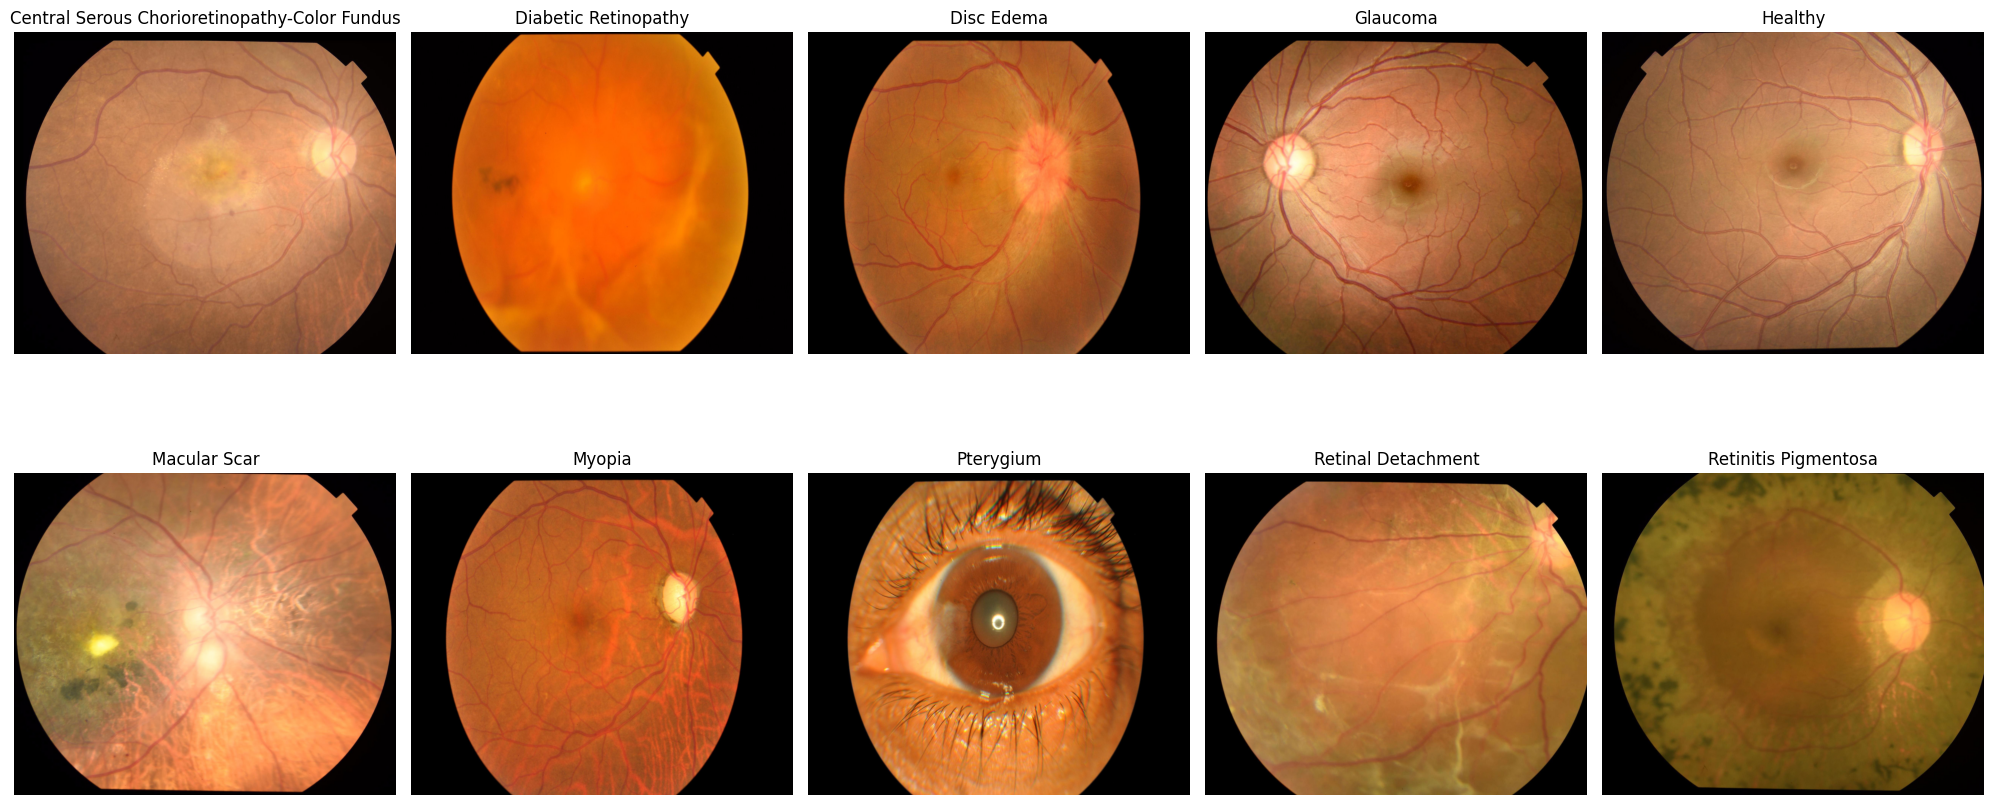

In [22]:


def show_random_images(dataset, num_images=1):
    # Create a grid with 5 images per row
    rows = len(dataset.dataset.classes) // 5 + (len(dataset.dataset.classes) % 5 > 0)
    fig, axes = plt.subplots(rows, 5, figsize=(20, 5 * rows))

    # Flatten axes in case the grid is not fully filled (when the number of classes is not a multiple of 5)
    axes = axes.flatten()

    for idx, cls in enumerate(dataset.dataset.classes):
        # Get the indices for images of the current class
        class_indices = [i for i, (_, label) in enumerate(dataset.dataset.samples) if dataset.dataset.classes[label] == cls]
        
        # Choose a random index for the class
        random_idx = random.choice(class_indices)
        img_path, _ = dataset.dataset.samples[random_idx]

        # Open and display the image
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis("off")
        axes[idx].set_title(cls)

    # Hide any unused axes (in case the number of classes is not divisible by 5)
    for i in range(len(dataset.dataset.classes), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Show one random image per class
show_random_images(train_dataset)

In [32]:

# import torchvision.models as models
# from torchvision.models import VGG16_Weights, MobileNet_V3_Large_Weights, DenseNet121_Weights

# def get_model(model_name, num_classes, freeze_layers=True):
#     if model_name == "MobileNetV3":
#         # Use the 'weights' parameter instead of 'pretrained'
#         model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
#         if freeze_layers:
#             for param in model.features.parameters():
#                 param.requires_grad = False
#         model.classifier = nn.Sequential(
#             nn.Linear(model.classifier[0].in_features, 512),
#             nn.ReLU(),
#             nn.Dropout(0.4),
#             nn.Linear(512, num_classes)
#         )
    
#     elif model_name == "VGG16":
#         # Use the 'weights' parameter instead of 'pretrained'
#         model = models.vgg16(weights=VGG16_Weights.DEFAULT)
#         if freeze_layers:
#             for param in model.features.parameters():
#                 param.requires_grad = False
#         model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    
#     elif model_name == "DenseNet121":
#         # Use the 'weights' parameter instead of 'pretrained'
#         model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
#         if freeze_layers:
#             for param in model.features.parameters():
#                 param.requires_grad = False
#         model.classifier = nn.Linear(model.classifier.in_features, num_classes)

#     return model.to(device)


In [33]:

# class EarlyStopping:
#     def __init__(self, patience=5):
#         self.patience = patience
#         self.best_loss = float('inf')
#         self.counter = 0

#     def should_stop(self, val_loss):
#         if val_loss < self.best_loss:
#             self.best_loss = val_loss
#             self.counter = 0
#         else:
#             self.counter += 1
#         return self.counter >= self.patience

In [34]:


# def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, early_stopping, epochs=20):
#     train_losses, val_losses = [], []

#     for epoch in range(epochs):
#         start_time = time.time()
        
#         model.train()
#         train_loss, correct_train = 0, 0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             correct_train += (outputs.argmax(1) == labels).sum().item()
        
#         train_acc = correct_train / len(train_loader.dataset)
#         train_loss /= len(train_loader)

#         model.eval()
#         val_loss, correct_val = 0, 0
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
#                 correct_val += (outputs.argmax(1) == labels).sum().item()
        
#         val_acc = correct_val / len(val_loader.dataset)
#         val_loss /= len(val_loader)

#         scheduler.step(val_loss)

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)

#         epoch_time = time.time() - start_time
#         print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")

#         if early_stopping.should_stop(val_loss):
#             print("Early stopping triggered.")
#             break

#     return train_losses, val_losses

In [35]:


# models_list = ["VGG16"]
# optimizers_list = [optim.Adam]

# best_model, best_loss = None, float("inf")

# for model_name in models_list:
#     for optimizer_type in optimizers_list:
#         print(f"\nTraining {model_name} with {optimizer_type.__name__} optimizer...\n")

#         model = get_model(model_name, num_classes)
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optimizer_type(model.parameters(), lr=0.001)
#         scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
#         early_stopping = EarlyStopping(patience=5)

#         train_losses, val_losses = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, early_stopping)

#         if val_losses[-1] < best_loss:
#             best_loss = val_losses[-1]
#             best_model = model_name

# print(f"\nBest Model: {best_model} with lowest validation loss: {best_loss:.4f}")


Training VGG16 with Adam optimizer...

Epoch 1/20 - Train Acc: 0.4583, Train Loss: 1.5653, Val Acc: 0.5526, Val Loss: 1.1998, Time: 522.27s
Epoch 2/20 - Train Acc: 0.5329, Train Loss: 1.3724, Val Acc: 0.6555, Val Loss: 1.0778, Time: 499.42s
Epoch 3/20 - Train Acc: 0.5808, Train Loss: 1.2127, Val Acc: 0.6795, Val Loss: 0.9813, Time: 516.40s
Epoch 4/20 - Train Acc: 0.6156, Train Loss: 1.1073, Val Acc: 0.6958, Val Loss: 0.9530, Time: 510.76s
Epoch 5/20 - Train Acc: 0.6352, Train Loss: 1.0609, Val Acc: 0.7014, Val Loss: 0.9536, Time: 535.59s
Epoch 6/20 - Train Acc: 0.6645, Train Loss: 1.0171, Val Acc: 0.6980, Val Loss: 0.8812, Time: 503.37s
Epoch 7/20 - Train Acc: 0.6746, Train Loss: 0.9558, Val Acc: 0.7115, Val Loss: 0.8658, Time: 513.44s
Epoch 8/20 - Train Acc: 0.7013, Train Loss: 0.8966, Val Acc: 0.7284, Val Loss: 0.8748, Time: 520.39s
Epoch 9/20 - Train Acc: 0.6984, Train Loss: 0.8860, Val Acc: 0.7522, Val Loss: 0.7727, Time: 509.90s
Epoch 10/20 - Train Acc: 0.7094, Train Loss: 0.8473

In [37]:

def get_model_mobilenetv3(num_classes, freeze_layers=True):
    # Load MobileNetV3 with pre-trained weights
    model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
    
    if freeze_layers:
        # Freeze all blocks in model.features except for the last two modules
        total_blocks = len(model.features)
        for idx, module in enumerate(model.features):
            if idx < total_blocks - 2:
                for param in module.parameters():
                    param.requires_grad = False
            else:
                # Unfreeze last two blocks
                for param in module.parameters():
                    param.requires_grad = True
    # Replace classifier with a custom head that includes dropout
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[0].in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

In [38]:

def get_model_densenet121(num_classes, freeze_layers=True):
    # Load DenseNet121 with pre-trained weights
    model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
    
    if freeze_layers:
        # For DenseNet121, model.features is a Sequential of various layers.
        # Unfreeze only the last two modules.
        features = list(model.features.children())
        total_blocks = len(features)
        for idx, module in enumerate(features):
            if idx < total_blocks - 2:
                for param in module.parameters():
                    param.requires_grad = False
            else:
                for param in module.parameters():
                    param.requires_grad = True
        # Note: The model.features remains a Sequential container.
    # Replace classifier with dropout and a linear layer.
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.classifier.in_features, num_classes)
    )
    return model.to(device)

In [39]:


class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0

    def should_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [40]:

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, early_stopping, epochs=20):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    all_val_labels, all_val_preds = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            preds = outputs.argmax(1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                preds = outputs.argmax(1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
                
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())
        
        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss)
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")
        
        if early_stopping.should_stop(val_loss):
            print("Early stopping triggered.")
            break
        
        if val_loss < early_stopping.best_loss:
            best_model_wts = copy.deepcopy(model.state_dict())
    
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs, all_val_labels, all_val_preds

In [41]:

def plot_accuracy_and_loss(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.grid(True)
    
    # Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



In [42]:

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_per_class_accuracy(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    per_class_accuracy = np.diag(cm) / cm.sum(axis=1)
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, per_class_accuracy, color="skyblue")
    plt.xlabel("Classes")
    plt.ylabel("Accuracy")
    plt.title("Per-Class Accuracy")
    plt.xticks(rotation=45)
    plt.show()

In [43]:

class_names = full_dataset.classes
print("Classes:", class_names)
num_classes = len(class_names)  # ensure class_names is defined from your dataset
epochs = 20
learning_rate = 0.001

Classes: ['Central Serous Chorioretinopathy-Color Fundus', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']



Training MobileNetV3 (unfreeze last 2 blocks) with Adam optimizer...

Epoch 1/20 - Train Acc: 0.6928, Train Loss: 0.8610, Val Acc: 0.7839, Val Loss: 0.6229, Time: 581.68s
Epoch 2/20 - Train Acc: 0.8208, Train Loss: 0.4795, Val Acc: 0.8162, Val Loss: 0.4968, Time: 429.85s
Epoch 3/20 - Train Acc: 0.8682, Train Loss: 0.3508, Val Acc: 0.8448, Val Loss: 0.4760, Time: 423.16s
Epoch 4/20 - Train Acc: 0.8983, Train Loss: 0.2728, Val Acc: 0.8387, Val Loss: 0.4701, Time: 423.88s
Epoch 5/20 - Train Acc: 0.9098, Train Loss: 0.2302, Val Acc: 0.8534, Val Loss: 0.4721, Time: 435.11s
Epoch 6/20 - Train Acc: 0.9172, Train Loss: 0.2078, Val Acc: 0.8421, Val Loss: 0.4841, Time: 435.41s
Epoch 7/20 - Train Acc: 0.9262, Train Loss: 0.1806, Val Acc: 0.8504, Val Loss: 0.4845, Time: 426.77s
Epoch 8/20 - Train Acc: 0.9320, Train Loss: 0.1626, Val Acc: 0.8541, Val Loss: 0.5016, Time: 425.53s
Epoch 9/20 - Train Acc: 0.9482, Train Loss: 0.1155, Val Acc: 0.8642, Val Loss: 0.4379, Time: 426.37s
Epoch 10/20 - Train 

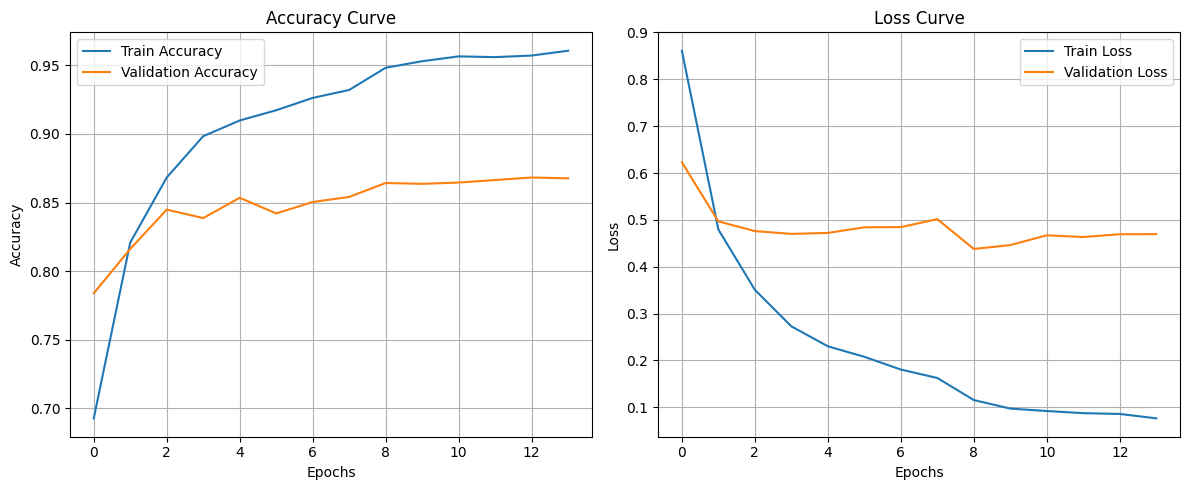

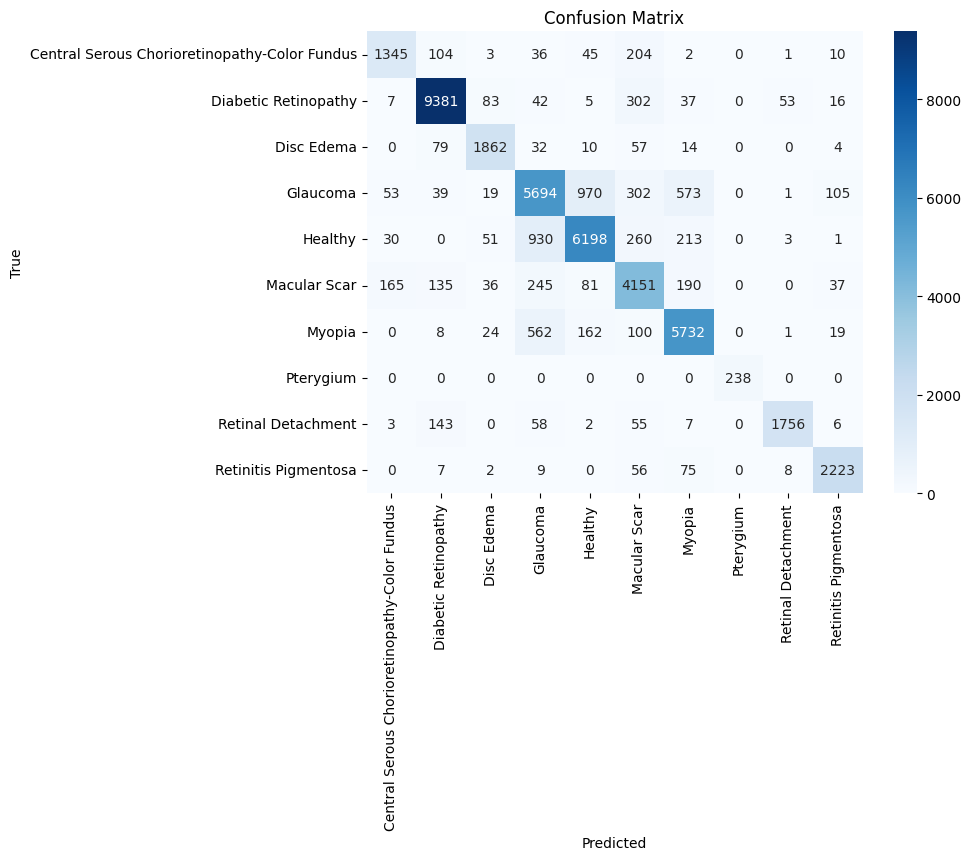

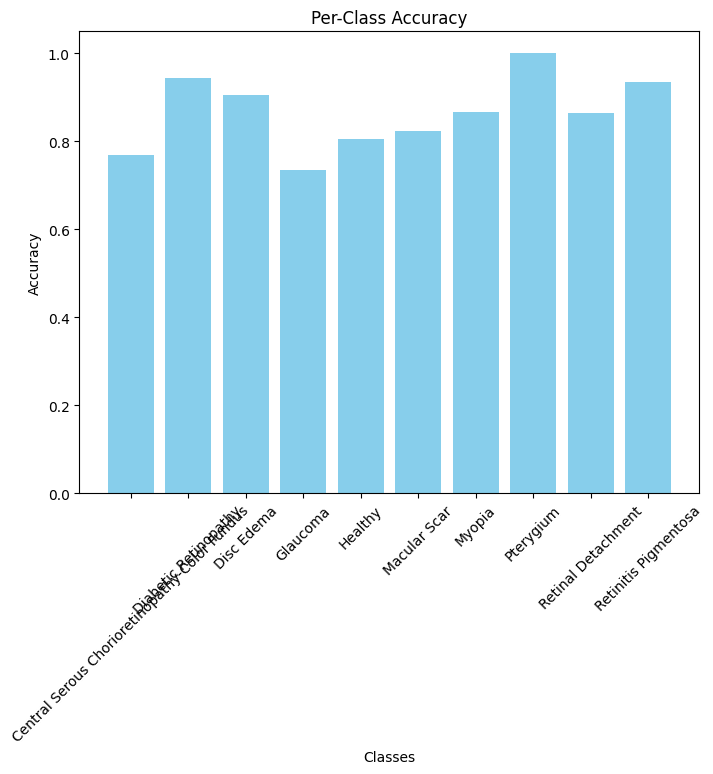

In [44]:

print("\nTraining MobileNetV3 (unfreeze last 2 blocks) with Adam optimizer...\n")
mobilenet_model = get_model_mobilenetv3(num_classes, freeze_layers=True)
optimizer_mnv3 = optim.Adam(mobilenet_model.parameters(), lr=learning_rate)
scheduler_mnv3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mnv3, mode='min', factor=0.1, patience=3)
early_stopping_mnv3 = EarlyStopping(patience=5)

mobilenet_model, train_losses_mnv3, val_losses_mnv3, train_accs_mnv3, val_accs_mnv3, val_labels_mnv3, val_preds_mnv3 = train_model(
    mobilenet_model, nn.CrossEntropyLoss(), optimizer_mnv3, scheduler_mnv3,
    train_loader, val_loader, early_stopping_mnv3, epochs=epochs
)

print("\nMobileNetV3 Training Completed.\n")
plot_accuracy_and_loss(train_losses_mnv3, val_losses_mnv3, train_accs_mnv3, val_accs_mnv3)
plot_confusion_matrix(val_labels_mnv3, val_preds_mnv3, class_names)
plot_per_class_accuracy(val_labels_mnv3, val_preds_mnv3, class_names)



In [ ]:

# ----- DenseNet121 -----
print("\nTraining DenseNet121 (unfreeze last 2 blocks) with Adam optimizer...\n")
densenet_model = get_model_densenet121(num_classes, freeze_layers=True)
optimizer_dn = optim.Adam(densenet_model.parameters(), lr=learning_rate)
scheduler_dn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_dn, mode='min', factor=0.1, patience=3)
early_stopping_dn = EarlyStopping(patience=5)

densenet_model, train_losses_dn, val_losses_dn, train_accs_dn, val_accs_dn, val_labels_dn, val_preds_dn = train_model(
    densenet_model, nn.CrossEntropyLoss(), optimizer_dn, scheduler_dn,
    train_loader, val_loader, early_stopping_dn, epochs=epochs
)

print("\nDenseNet121 Training Completed.\n")
plot_accuracy_and_loss(train_losses_dn, val_losses_dn, train_accs_dn, val_accs_dn)
plot_confusion_matrix(val_labels_dn, val_preds_dn, class_names)
plot_per_class_accuracy(val_labels_dn, val_preds_dn, class_names)



Training DenseNet121 (unfreeze last 2 blocks) with Adam optimizer...

Epoch 1/20 - Train Acc: 0.7174, Train Loss: 0.7817, Val Acc: 0.7940, Val Loss: 0.5709, Time: 477.10s
Epoch 2/20 - Train Acc: 0.8249, Train Loss: 0.4765, Val Acc: 0.8368, Val Loss: 0.4379, Time: 467.00s
